In [1]:
# !pip install datasets

In [3]:
# !pip install pandas


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Reading the Legal Cases Dataframe
* case_id - represents a unique id for each case
* text - represents the complaint text for each case
* domain - the domain name of which this case belongs to

In [3]:
from datasets import load_dataset
dataset = load_dataset('darrow-ai/legal-task')
dataset = dataset['train'].to_pandas()
dataset.head()

,id,text,domain
0,r-e4EYcBD5gMZwcz41zP,UNITED STATES DISTRICT COURT \nEASTERN DISTRIC...,consumer fraud
1,i9H5DocBD5gMZwcztj0y,IN THE UNITED STATES DISTRICT COURT \nFOR THE ...,privacy
2,SMn3DYcBD5gMZwcz-hwH,IN THE UNITED STATES DISTRICT COURT\n FOR THE ...,privacy
3,GMIWDYcBD5gMZwczDQBb,Case No. _______________ \n \n \nCLASS ACTION ...,criminal & enforcement
4,lELw_IgBF5pVm5zYONwC,UNITED STATES DISTRICT COURT \n SOUTHERN DISTR...,consumer fraud


In [8]:
dataset.id.count()

np.int64(1204)

In [7]:
dataset.groupby('domain').agg(
    total_count=('id', 'count'),
    distinct_count=('id', 'nunique')
)


,total_count,distinct_count
domain,,
antitrust,126,126
"civil rights, immigration, family",167,167
consumer fraud,200,200
criminal & enforcement,16,16
discrimination,20,20
employment & labor,200,200
environmental & natural resources,3,3
healthcare,9,9
intellectual property & communication,7,7


In [31]:
# print(dataset.sample(1).text.iloc[0])


# Data Preprocessing

## Check For Duplicates

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 300)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

print("Initial shape:", dataset.shape)

# Find all rows that are duplicated on the exact pair (id, text)
dup_mask = dataset.duplicated(subset=["id", "text"], keep=False)
duplicates_df = dataset[dup_mask].copy()

print(f"Number of rows involved in [id, text] duplicates: {duplicates_df.shape[0]}")

# Save them for transparency / potential manual inspection
if not duplicates_df.empty:
    duplicates_df.to_csv("duplicates_id_text.csv", index=False)
    print("Saved [id, text] duplicates to 'duplicates_id_text.csv'.")

# Now create a deduplicated version keeping the first occurrence
dataset_deduped = dataset.drop_duplicates(subset=["id", "text"], keep="first").reset_index(drop=True)

print("Shape after deduplication on [id, text]:", dataset_deduped.shape)


Initial shape: (1204, 3)
Number of rows involved in [id, text] duplicates: 0
Shape after deduplication on [id, text]: (1204, 3)


## Distribution of Case Labels

| Domain                                |   Count | Share of total   |
|---------------------------------------|---------|------------------|
| consumer fraud                        |     200 | 16.61%           |
| privacy                               |     200 | 16.61%           |
| securities                            |     200 | 16.61%           |
| employment & labor                    |     200 | 16.61%           |
| civil rights, immigration, family     |     167 | 13.87%           |
| antitrust                             |     126 | 10.47%           |
| products liability and mass tort      |      56 | 4.65%            |
| discrimination                        |      20 | 1.66%            |
| criminal & enforcement                |      16 | 1.33%            |
| healthcare                            |       9 | 0.75%            |
| intellectual property & communication |       7 | 0.58%            |
| environmental & natural resources     |       3 | 0.25%            |


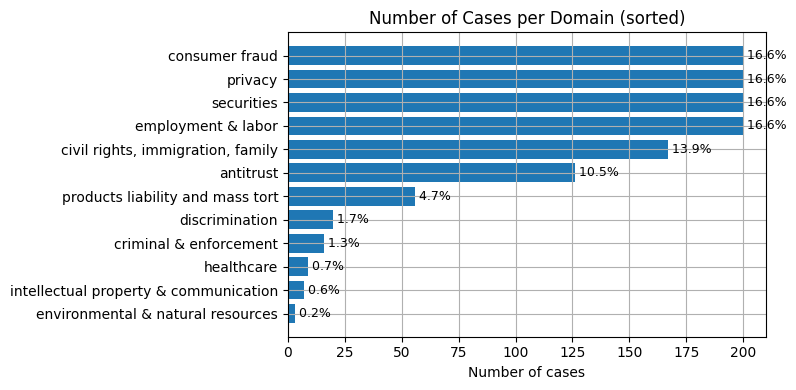

In [13]:
from tabulate import tabulate

# Counts & percentages
label_counts = dataset_deduped["domain"].value_counts()              # already sorted desc by count
total = label_counts.sum()
label_perc = (label_counts / total * 100)

# Tabular view (raw + %)
label_table = [
    [label, int(count), f"{pct:.2f}%"]
    for label, count, pct in zip(label_counts.index, label_counts.values, label_perc.values)
]
print(tabulate(label_table,
               headers=["Domain", "Count", "Share of total"],
               tablefmt="github"))

# Horizontal bar plot, sorted by count (desc)
fig, ax = plt.subplots(figsize=(8, 4))

y_pos = range(len(label_counts))
ax.barh(y_pos, label_counts.values)
ax.set_yticks(y_pos)
ax.set_yticklabels(label_counts.index)
ax.invert_yaxis()  # largest on top

ax.set_xlabel("Number of cases")
ax.set_title("Number of Cases per Domain (sorted)")

# Add percentage labels to bars
for i, (cnt, pct) in enumerate(zip(label_counts.values, label_perc.values)):
    ax.text(cnt, i, f" {pct:.1f}%", va="center", ha="left", fontsize=9)

plt.tight_layout()
plt.show()


## Text Lengths (characters and Tokens)

For the exploratory analysis, token counts are computed using a simple whitespace-based tokenizer.

This is efficient and sufficient to compare document length distributions across domains.

For the modeling and similarity steps, we rely on transformer-based embeddings that use more advanced
subword tokenization under the hood.


In [18]:
# import spacy
#
# # Load a lightweight English model, disable heavy components for speed
# try:
#     nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "lemmatizer"])
# except OSError:
#     # If not installed in your venv, run this once, then re-run the cell
#     !python -m spacy download en_core_web_sm
#     nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "lemmatizer"])
#
# texts = dataset_deduped["text"].astype(str).tolist()
# token_counts = []
#
# # Efficient batched processing
# for doc in nlp.pipe(texts, batch_size=64):
#     token_counts.append(sum(1 for t in doc if not t.is_space))
#
# dataset_deduped["len_tokens"] = token_counts
# dataset_deduped[["len_chars", "len_tokens"]].describe()


In [19]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
#
# # encode_batch returns token counts instantly (runs in Rust)
# dataset_deduped["len_tokens"] = dataset_deduped["text"].astype(str).apply(lambda x: len(tokenizer.tokenize(x)))


In [20]:
# Character length (already good)
dataset_deduped["len_chars"] = dataset_deduped["text"].astype(str).str.len()

# Fast token length:
# - split on any whitespace
# - ignore empty strings implicitly
dataset_deduped["len_tokens"] = dataset_deduped["text"].astype(str).str.split().str.len()

dataset_deduped[["len_chars", "len_tokens"]].describe()


,len_chars,len_tokens
count,1204.000000,1204.000000
mean,41953.988372,6227.509136
std,41826.614633,6127.249463
min,1035.000000,139.000000
25%,17422.000000,2640.500000
50%,31180.500000,4688.500000
75%,50414.500000,7411.500000
max,441073.000000,66981.000000


### Compare Text Lengths by Domain

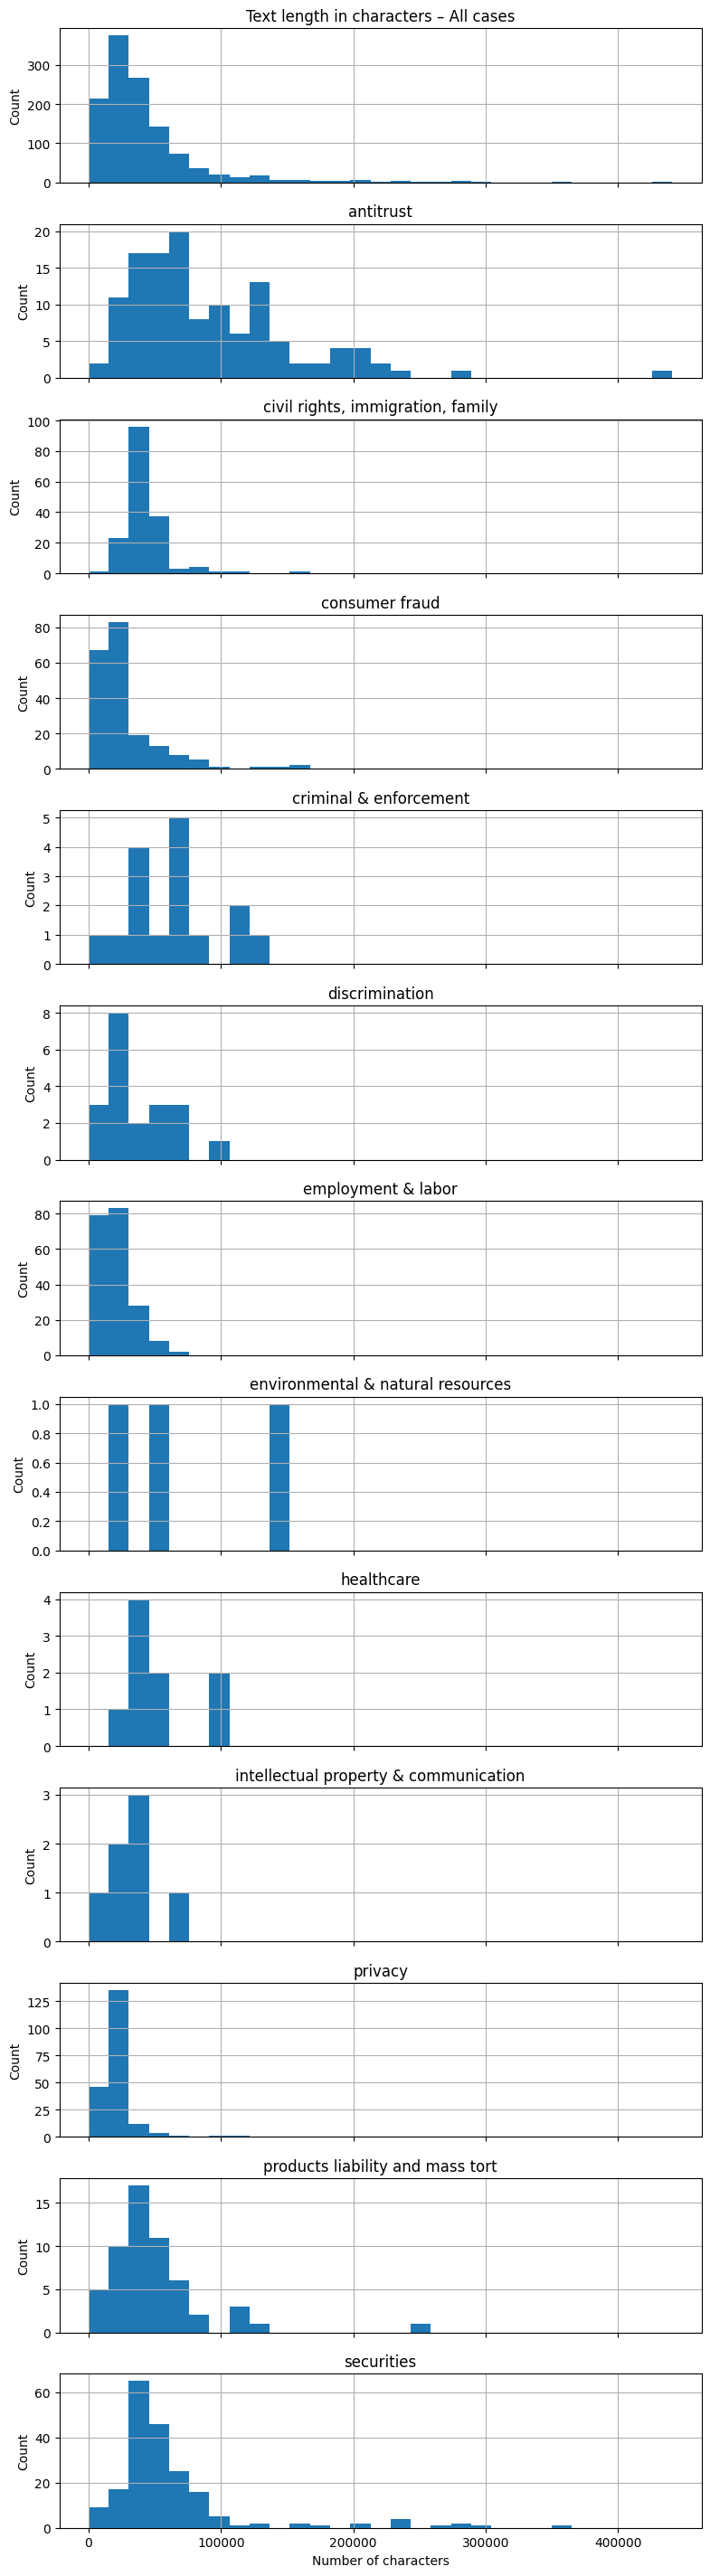

In [21]:
df = dataset_deduped.copy()
domains = sorted(dataset_deduped["domain"].unique())
n_labels = len(domains)
bins_chars = np.linspace(0, dataset_deduped["len_chars"].max(), 30)

fig, axes = plt.subplots(n_labels + 1, 1,
                         figsize=(8, 2.2 * (n_labels + 1)),
                         sharex=True)

# Global distribution
axes[0].hist(df["len_chars"], bins=bins_chars)
axes[0].set_title("Text length in characters – All cases")
axes[0].set_ylabel("Count")

# Per-domain distributions
for i, domain in enumerate(domains, start=1):
    subset = df.loc[df["domain"] == domain, "len_chars"]
    axes[i].hist(subset, bins=bins_chars)
    axes[i].set_title(f"{domain}")
    axes[i].set_ylabel("Count")

axes[-1].set_xlabel("Number of characters")
plt.tight_layout()
plt.show()


### Compare Token Lengths Per Domain

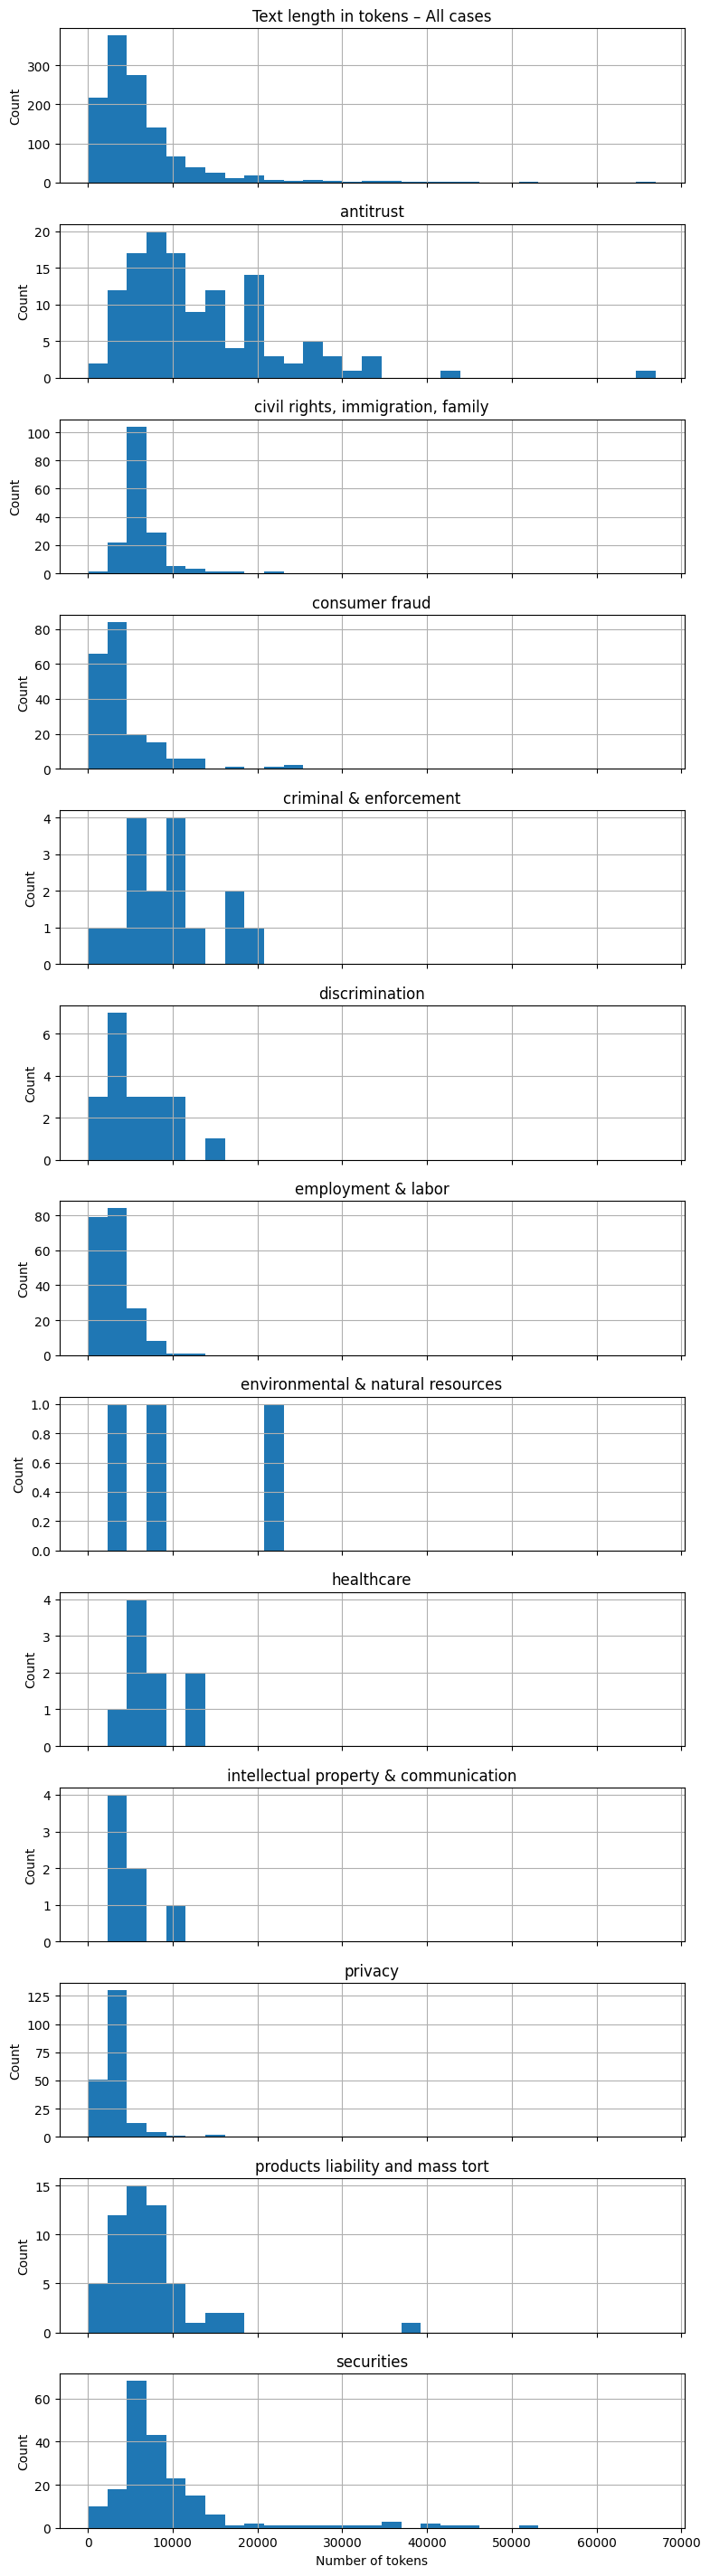

In [22]:
bins_tokens = np.linspace(0, dataset_deduped["len_tokens"].max(), 30)

fig, axes = plt.subplots(n_labels + 1, 1,
                         figsize=(8, 2.2 * (n_labels + 1)),
                         sharex=True)

# Global
axes[0].hist(dataset_deduped["len_tokens"], bins=bins_tokens)
axes[0].set_title("Text length in tokens – All cases")
axes[0].set_ylabel("Count")

# Per-domain
for i, domain in enumerate(domains, start=1):
    subset = dataset_deduped.loc[df["domain"] == domain, "len_tokens"]
    axes[i].hist(subset, bins=bins_tokens)
    axes[i].set_title(f"{domain}")
    axes[i].set_ylabel("Count")

axes[-1].set_xlabel("Number of tokens")
plt.tight_layout()
plt.show()


### Characters Per Token

This ratio measures the average word “length” in each document, giving an indirect sense of
lexical complexity and formatting cleanliness.

- Typical values around 4–6 indicate normal English tokens.
- Higher averages may signal excessive punctuation or lack of whitespace (e.g., OCR artifacts).
- Comparing per-domain distributions helps identify if certain legal domains use systematically
longer or shorter terms (e.g., *criminal & enforcement* vs. *privacy* cases).


In [24]:
# Avoid divide-by-zero
dataset_deduped["chars_per_token"] = dataset_deduped.apply(
    lambda r: r["len_chars"] / r["len_tokens"] if r["len_tokens"] > 0 else np.nan,
    axis=1
)

dataset_deduped["chars_per_token"].describe()


count    1204.000000
mean        6.724957
std         1.223395
min         5.138686
25%         6.567063
50%         6.673313
75%         6.804116
max        42.764706
Name: chars_per_token, dtype: float64

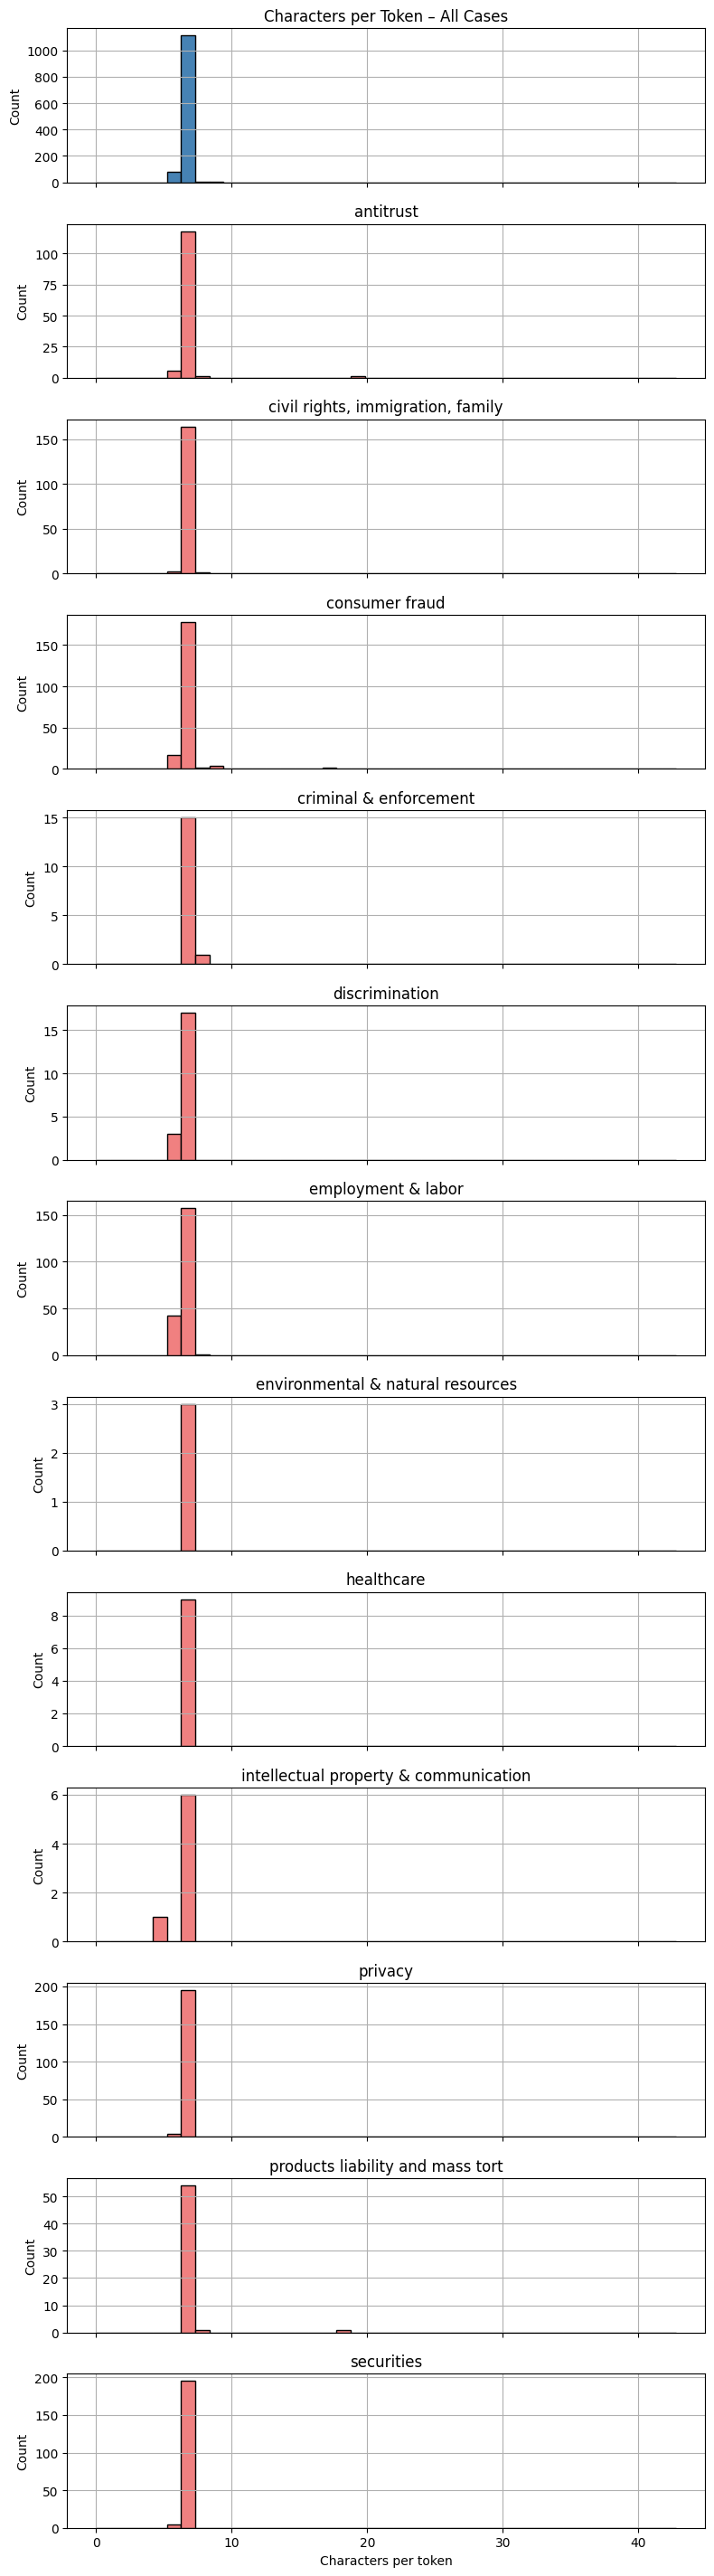

In [36]:
import numpy as np
import matplotlib.pyplot as plt

domains = sorted(dataset_deduped["domain"].unique())
n_labels = len(domains)
bins_cpt = np.linspace(0, dataset_deduped["chars_per_token"].dropna().max(), int(dataset_deduped["chars_per_token"].dropna().max()))


fig, axes = plt.subplots(n_labels + 1, 1,
                         figsize=(8, 2.2 * (n_labels + 1)),
                         sharex=True)

# --- Global distribution ---
axes[0].hist(df["chars_per_token"].dropna(), bins=bins_cpt, color="steelblue", edgecolor="black")
axes[0].set_title("Characters per Token – All Cases")
axes[0].set_ylabel("Count")

# --- Per-domain distributions ---
for i, domain in enumerate(domains, start=1):
    subset = df.loc[df["domain"] == domain, "chars_per_token"].dropna()
    axes[i].hist(subset, bins=bins_cpt, color="lightcoral", edgecolor="black")
    axes[i].set_title(domain)
    axes[i].set_ylabel("Count")

axes[-1].set_xlabel("Characters per token")
plt.tight_layout()
plt.show()


### Distribution of Percentage of Blanck Characters

In [37]:
def blank_char_ratio(text: str) -> float:
    if not isinstance(text, str):
        return np.nan
    if len(text) == 0:
        return np.nan

    total = len(text)
    blanks = 0
    for ch in text:
        if ch == " " or ch == "\n":
            blanks += 1

    return blanks / total if total > 0 else np.nan

dataset_deduped["blank_ratio"] = dataset_deduped["text"].apply(blank_char_ratio)

print(dataset_deduped["blank_ratio"].describe())


count    1204.000000
mean        0.185432
std         0.016932
min         0.037254
25%         0.178339
50%         0.185850
75%         0.193860
max         0.319264
Name: blank_ratio, dtype: float64


The blank-character ratio is mostly stable across domains, confirming that formatting and
whitespace usage are consistent. Outliers with unusually high or low ratios may indicate
noisy or truncated texts and are candidates for further inspection.


In [41]:
# plt.hist(dataset_deduped["blank_ratio"].dropna(), bins=30)
# plt.title("Distribution of blank-character ratio")
# plt.xlabel("Blank characters / total characters")
# plt.ylabel("Number of cases")
# plt.show()


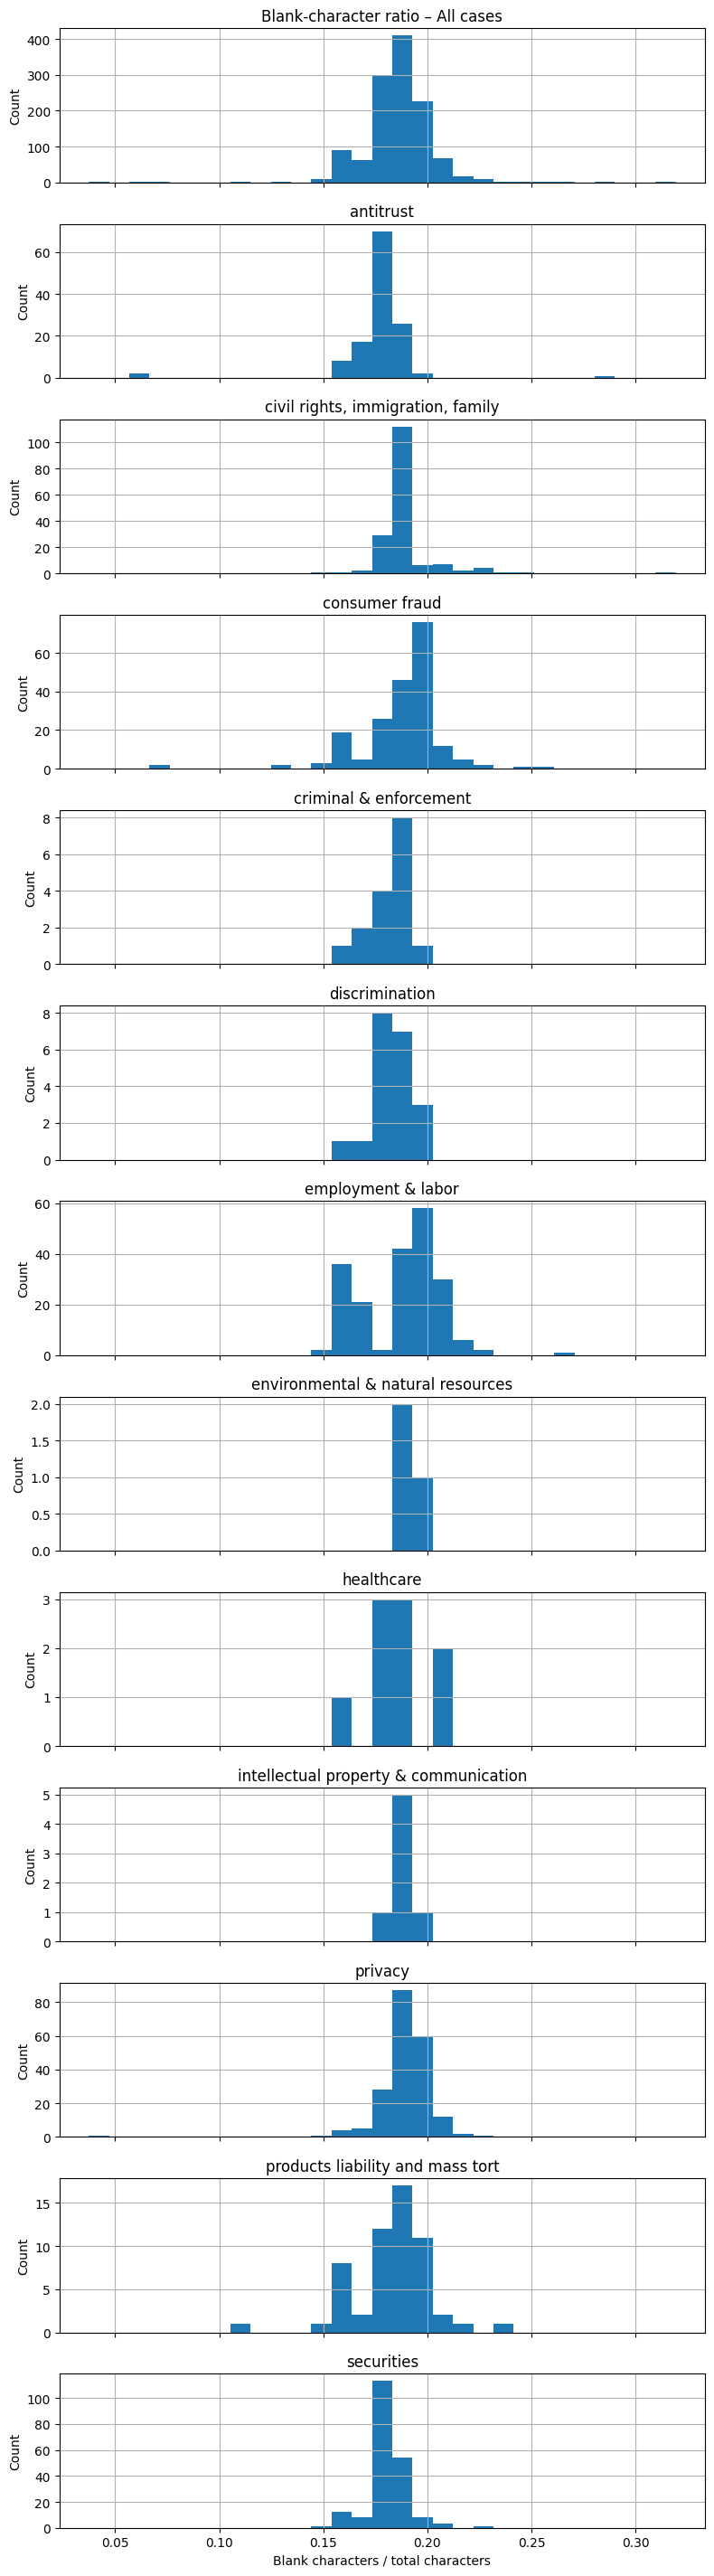

In [40]:
domains = sorted(df["domain"].unique())
n_labels = len(domains)

# Use only valid values for binning
valid_blank = dataset_deduped["blank_ratio"].dropna()

# If everything is super tight, still make a sensible range
min_br = max(0.0, valid_blank.min())
max_br = min(1.0, valid_blank.max())
bins_blank = np.linspace(min_br, max_br, 30)

fig, axes = plt.subplots(
    n_labels + 1,
    1,
    figsize=(8, 2.2 * (n_labels + 1)),
    sharex=True
)

# --- Global distribution ---
axes[0].hist(valid_blank, bins=bins_blank)
axes[0].set_title("Blank-character ratio – All cases")
axes[0].set_ylabel("Count")

# --- Per-domain distributions ---
for i, domain in enumerate(domains, start=1):
    subset = dataset_deduped.loc[dataset_deduped["domain"] == domain, "blank_ratio"].dropna()
    axes[i].hist(subset, bins=bins_blank)
    axes[i].set_title(domain)
    axes[i].set_ylabel("Count")

axes[-1].set_xlabel("Blank characters / total characters")
plt.tight_layout()
plt.show()


### Text cleaning

In [12]:
def clean_text(text: str) -> str:
    # Ensure string
    text = str(text)

    # Collapse all whitespace (spaces, newlines, tabs) into a single space
    text = re.sub(r"\s+", " ", text)

    # Strip leading/trailing spaces
    text = text.strip()

    # Lowercase for modeling consistency
    text = text.lower()

    return text

dataset_deduped["text_clean"] = dataset_deduped["text"].apply(clean_text)

dataset_deduped[["id", "domain", "text_clean"]].head()


,id,domain,text_clean
0,r-e4EYcBD5gMZwcz41zP,consumer fraud,"united states district court eastern district of new york chaya r. denciger, individually and on behalf of all others similarly situated, civil action no: 1:19-cv-4581 ____________ plaintiff, jury demand -v.- first credit incorporated, and john does 1-25. defendant(s) class action complaint plai..."
1,i9H5DocBD5gMZwcztj0y,privacy,"in the united states district court for the district of kansas george jones, on behalf ) of himself and all others similarly situated ) ) plaintiff ) ) case no.: v. ) ) ad astra recovery services, ) inc. ) ) defendant. ) introduction 1. george jones (“plaintiff”) brings this class action complai..."
2,SMn3DYcBD5gMZwcz-hwH,privacy,"in the united states district court for the western district of pennsylvania pittsburgh division ________________________________________ mark fitzhenry, individually and on behalf of a class of all persons and entities similarly situated, plaintiff case no. class action complaint guardian prote..."
3,GMIWDYcBD5gMZwczDQBb,criminal & enforcement,"case no. _______________ class action complaint for violations of the federal racketeer influenced and corrupt organizations act, the ohio corrupt activity act, and civil conspiracy jury trial demanded in the united states district court for the southern district of ohio eastern division brian h..."
4,lELw_IgBF5pVm5zYONwC,consumer fraud,"united states district court southern district of new york 1:21-cv-06866 bobby phillips, individually and on behalf of all others similarly situated, plaintiff, - against - class action complaint johnson & johnson consumer inc., jury trial demanded defendant plaintiff alleges upon information an..."


We apply minimal normalization:
- Normalize whitespace (including newlines).
- Lowercase the text.

We intentionally keep punctuation, legal entities, and terminology, as they may carry
useful signal for distinguishing legal domains.
